<a href="https://colab.research.google.com/github/ehsan-lari/pyro101/blob/main/pyro_07_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto Encoder (VAE)
---

In [ ]:
!pip install -q --upgrade pyro-ppl

In [ ]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import datetime
import os
import matplotlib.gridspec as gridspec
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import copy
import seaborn as sns
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import warnings
warnings.filterwarnings("ignore")

In [29]:
torch.random.manual_seed(42)

def get_data_sample(digits = [1, 2, 3], image_per_class = 100):

  mnist = datasets.MNIST(root='./data/', train=True, download=True)

  select = np.array([], dtype=int)
  for i in digits:
    select = np.concatenate((select,
                             np.random.choice(np.where(mnist.targets == i)[0],
                                              size=image_per_class,
                                              replace=False)))

  mnist.data[mnist.data <= 128] = 0
  mnist.data[mnist.data > 128] = 1

  mnist.data = mnist.data[select,:,:].type(torch.float)
  mnist.targets = mnist.targets[select].reshape(image_per_class*len(digits), -1)

  return mnist

In [30]:
digits = [1, 2, 3]
data = get_data_sample(digits=digits)

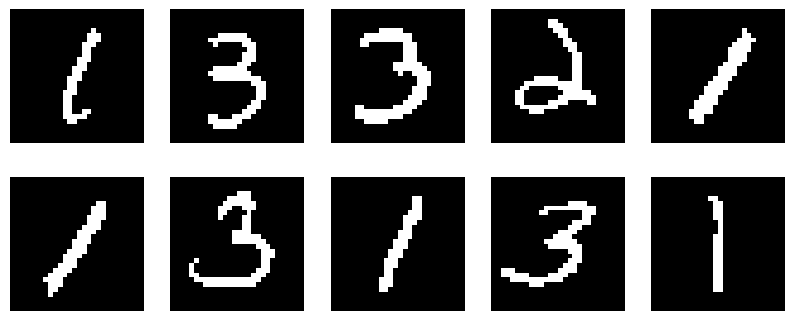

In [31]:
def display_image(x):
    plt.figure(figsize=(10,4))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(x[i].reshape((28, 28)), cmap="gray")
        # plt.title(x[i].targets)
        plt.axis('off')

toy_image = data.data[np.random.random_integers(0,300,10),:]
display_image(toy_image)

In [32]:
class VAE(nn.Module):
    def __init__(self, z_dim, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.z_dim = z_dim

    def model(self, x):
      pyro.module("decoder", self.decoder)
      with pyro.plate("data", x.shape[0]):
          z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
          z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
          z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
          loc_img = self.decoder.forward(z)
          pyro.sample('obs', dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    def guide(self, x):
      pyro.module("encoder", self.encoder)
      with pyro.plate("data", x.shape[0]):
          z_loc, z_scale  = self.encoder.forward(x)
          pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def sample_images(self, z, num_images = 5):
      if type(z) is not torch.Tensor:
        z = torch.tensor(z, dtype=torch.float32)
      logits = self.decoder.forward(z)
      distribution = dist.Bernoulli(logits=logits)

      f, ax = plt.subplots(1 , num_images+1, figsize=(10, 10), sharex=True)
      plt.axis('off')
      ax[0].imshow(distribution.mean.detach().numpy().reshape(28, 28), cmap='gray')
      ax[0].set_xlabel('Mean of Distribution')
      for i in range(num_images+1):
        ax[i].imshow(distribution.sample().detach().numpy().reshape(28, 28), cmap='gray')
        ax[i].set_xlabel(f"Sample {i+1}")
      plt.show()

    def reconstruct_image(self, num_images = 5):
      select_idx = np.random.choice(data.data.shape[0], num_images, replace=False)
      f, ax = plt.subplots(1 , num_images, figsize=(10, 10), sharex=True)
      plt.tight_layout()
      for idx, i in enumerate(select_idx):
        img = data.data[i, :]
        ax[idx].imshow(img.reshape(28, 28), cmap='gray')
      plt.show()

      f, ax = plt.subplots(1 , num_images, figsize=(10, 10), sharex=True)
      plt.tight_layout()
      for idx, i in enumerate(select_idx):
        img = data.data[i, :]
        z_loc, _ = self.encoder(img)
        logits = self.decoder.forward(z_loc)
        img_mean = dist.Bernoulli(logits=logits).mean
        ax[idx].imshow(img_mean.detach().numpy().reshape(28, 28), cmap='gray')
      plt.show()

## Encoder

In [33]:
class Encoder(nn.Module):
  def __init__(self, z_dim, hidden):
    super(Encoder, self).__init__()
    self.fc1 = nn.Linear(784, hidden)
    self.fc21 = nn.Linear(hidden, z_dim)
    self.fc22 = nn.Linear(hidden, z_dim)
    self.nonlin = nn.ReLU()

  def forward(self, x):
    x = x.reshape(-1, 784)
    z_loc = self.fc21(self.nonlin(self.fc1(x)))
    z_scale = nn.functional.softplus(self.fc22(self.nonlin(self.fc1(x))))
    return z_loc, z_scale

In [ ]:
# class Encoder_CNN(nn.Module):
#   def __init__(self, z_dim, hidden):
#     super(Encoder_CNN, self).__init__()
#     self.conv1 = nn.Conv2d(in_channels=1,
#                          out_channels=hidden,
#                          kernel_size=3)
#     self.conv2 = nn.Conv2d(in_channels=hidden,
#               out_channels=hidden,
#               kernel_size=3)
#     self.nonlin = nn.ReLU()

#   def forward(self, x):
#     x = x.reshape(-1, 1, 28, 28)


## Decoder

In [68]:
class Decoder(nn.Module):
  def __init__(self, z_dim, hidden):
    super(Decoder, self).__init__()
    self.fc1 = nn.Linear(z_dim, hidden)
    self.fc2 = nn.Linear(hidden, 784)
    self.nonlin = nn.ReLU()

  def forward(self, x):
    return nn.Softmax(dim=1)(self.fc2(self.nonlin(self.fc1(x))))

## Training

In [55]:
def train (svi, data):
  loss = svi.step(data)
  loss /= data.shape[0]
  return loss

Epoch: 0 Loss: 646.7240397135416


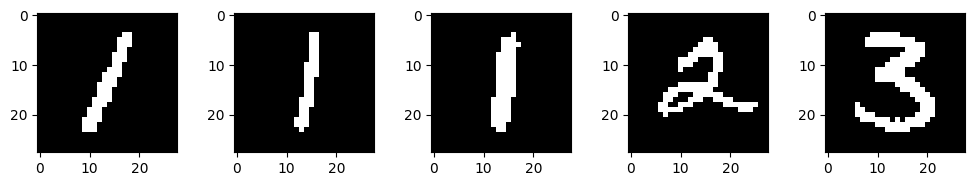

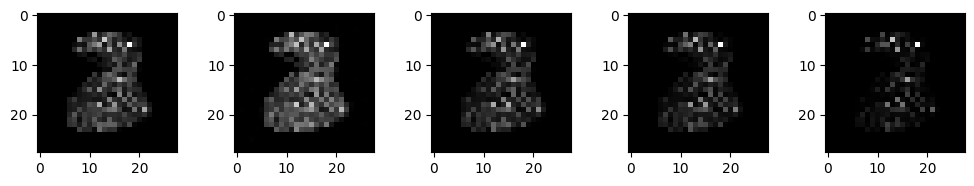

Epoch: 100 Loss: 521.9157386271158
Epoch: 200 Loss: 510.92613688151044
Epoch: 300 Loss: 504.7678759765625
Epoch: 400 Loss: 501.7502443440755
Epoch: 500 Loss: 499.44670532226564


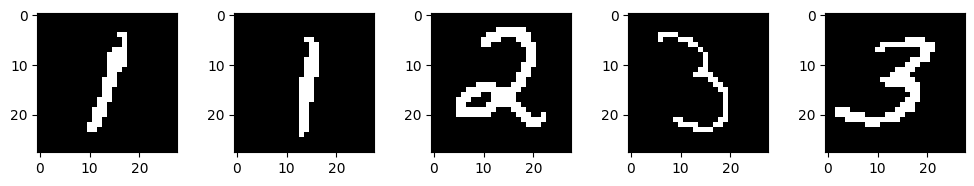

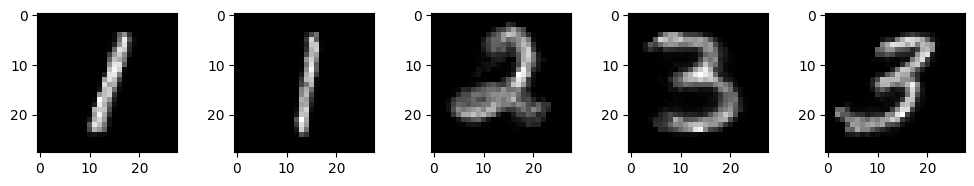

Epoch: 600 Loss: 496.9884983317057
Epoch: 700 Loss: 495.8096219889323
Epoch: 800 Loss: 493.73371337890626
Epoch: 900 Loss: 492.6037658691406


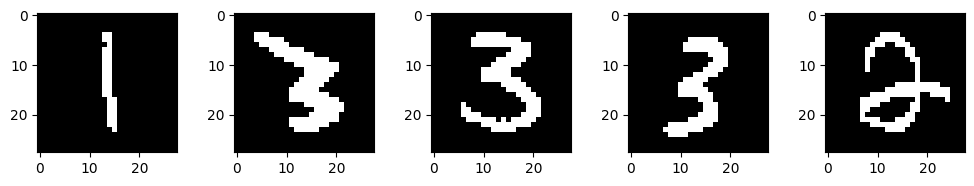

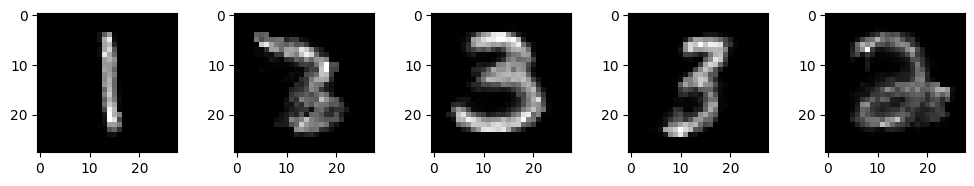

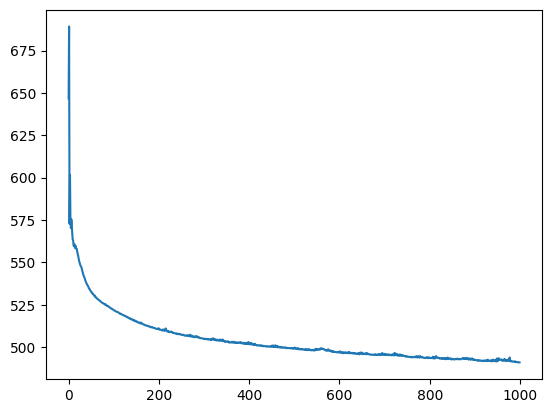

In [69]:
Z_DIM = 2

vae = VAE(z_dim=Z_DIM,
          encoder=Encoder(z_dim=Z_DIM, hidden=512),
          decoder=Decoder(z_dim=Z_DIM, hidden=512))

LR = 0.01

EPOCHS = 1000

pyro.clear_param_store()

adam_params = {"lr": LR}
optimizer = Adam(adam_params)

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_loss = []

for epoch in range(EPOCHS):
  loss = train(svi, data.data)
  train_loss.append(loss)
  if epoch % 100 == 0:
    print("Epoch: {} Loss: {}".format(epoch, loss))
  if epoch % 500 == 0:
    vae.reconstruct_image()
vae.reconstruct_image()
plt.plot(train_loss)
plt.show()

## Explore latent space

In [76]:
def plot_latent_space(vae):
  z_loc, z_scale = vae.encoder(data.data)
  z_loc = z_loc.detach().numpy()

  legends = [f"Digit {i}" for i in digits]
  plt.figure(figsize=(10,10))

  for idx, i in enumerate(digits):
    plt.scatter(z_loc[data.targets.numpy() == i, 0], z_loc[data.targets.numpy() == i, 1], label=legends[idx])

  plt.xlabel(r"$Z_0$")
  plt.ylabel(r"$Z_1$")
  plt.legend()
  plt.show()

plot_latent_space(vae)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

<Figure size 1000x1000 with 0 Axes>

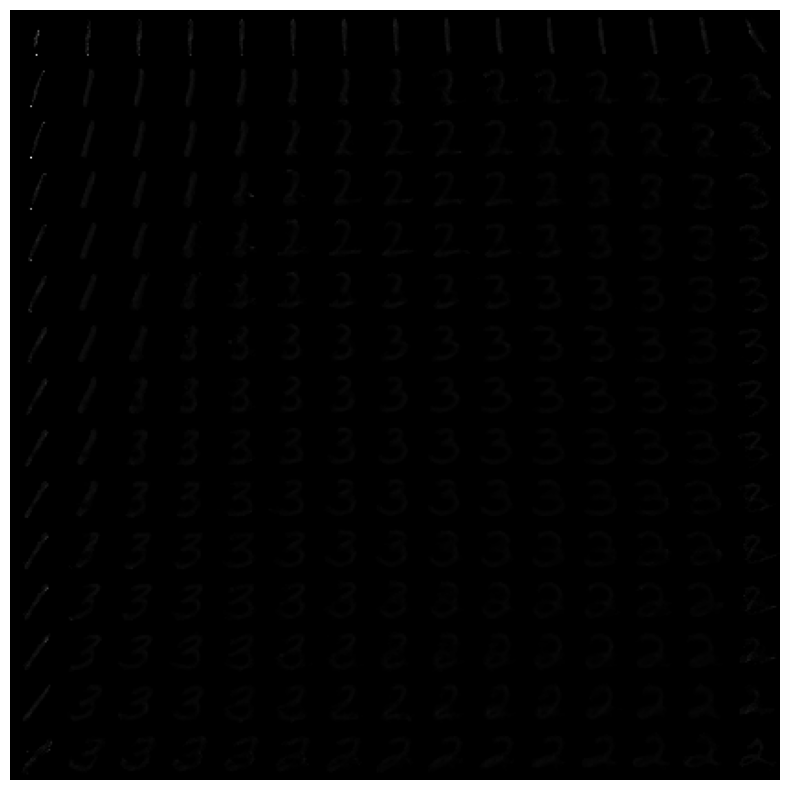

In [77]:
def plot_latent_space(vae: VAE, no_images: int = 15, img_size: int = 28):
    """
    Plot the latent space of the VAE
    """
    # Set up "target" z-values
    # linearly spaced coordinates on the unit square were transformed
    # through the inverse CDF (ppf) of the Gaussian to produce values
    # of the latent variables z, since the prior of the latent space
    # is Gaussian
    z1 = norm.ppf(np.linspace(0.001, 0.999, no_images))
    z2 = norm.ppf(np.linspace(0.999, 0.001, no_images)) # Flipped compared to z1 to make the figures comparable

    z_grid = np.dstack(np.meshgrid(z1, z2)).reshape(-1, 2)  # shape [no_images**2, z_dim]
    x_pred_grid = vae.decoder.forward(
        torch.tensor(z_grid, dtype=torch.float)
    ).detach().numpy().reshape(no_images, no_images, img_size, img_size)

    images = dist.Bernoulli(logits=torch.tensor(x_pred_grid)).mean.detach().numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.block(list(map(list, images))), cmap='gray')
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.ticker.NullLocator())
    plt.box(False)
    plt.show()

plot_latent_space(vae)

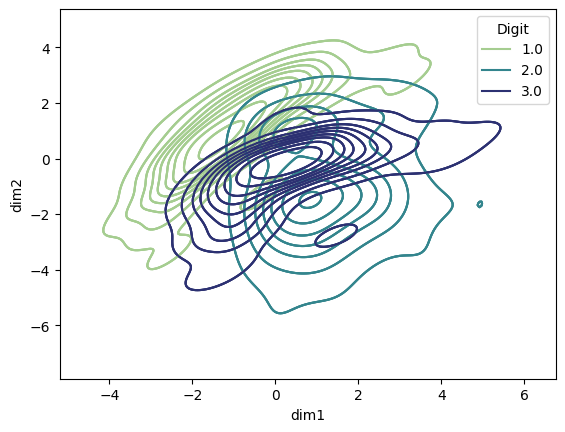

In [78]:
def plot_posterior(model):
    z_samples,_ = model.encoder(data.data)
    z_samples = z_samples.detach().numpy()
    z_class = data.targets.detach().numpy()

    for c in digits:
        sns.kdeplot(data=pd.DataFrame(np.hstack((z_samples,z_class.reshape(-1,1))), columns=["dim1", "dim2", "Digit"]),
                    x="dim1", y="dim2", hue="Digit", palette="crest")
    plt.show()

plot_posterior(vae)

In [88]:
class FancyDecoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1, hidden_dim2):
        super(FancyDecoder, self).__init__()

        # Define the first layer
        self.fc1 = nn.Linear(z_dim, hidden_dim1)

        # Define the first layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)

        # Define the last layer
        self.fc3 = nn.Linear(hidden_dim2, 784)

        # Define the non-linearities
        self.non_linearity = nn.ReLU()

    def forward(self, z):
        # define the forward computation on the latent z

        # first compute the hidden units
        hidden = self.non_linearity(self.fc1(z))
        hidden = self.non_linearity(self.fc2(hidden))

        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        logits_img = self.fc3(hidden)

        return nn.Softmax(dim=1)(logits_img)

In [84]:
class FancyEncoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1, hidden_dim2):
        super(FancyEncoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc31 = nn.Linear(hidden_dim2, z_dim)
        self.fc32 = nn.Linear(hidden_dim2, z_dim)
        # setup the non-linearities
        self.non_linearity = nn.ReLU()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.non_linearity(self.fc1(x))
        hidden = self.non_linearity(self.fc2(hidden))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc31(hidden)
        z_scale =nn.functional.softplus(self.fc32(hidden))
        return z_loc, z_scale

[epoch 000] average training loss: 644.8004


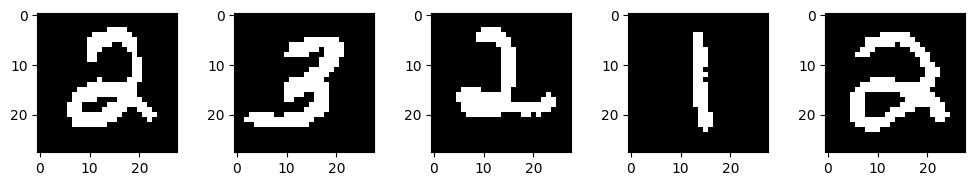

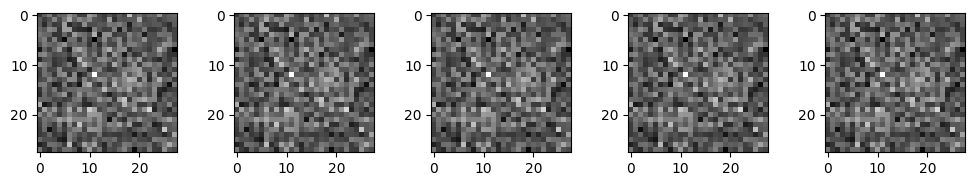

[epoch 100] average training loss: 539.4260
[epoch 200] average training loss: 520.1428
[epoch 300] average training loss: 514.5100
[epoch 400] average training loss: 511.6051
[epoch 500] average training loss: 509.5178


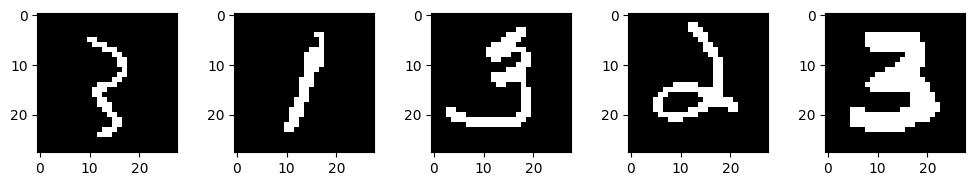

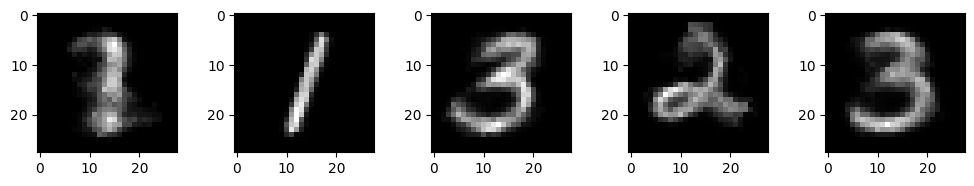

[epoch 600] average training loss: 507.3112
[epoch 700] average training loss: 505.8484
[epoch 800] average training loss: 504.2147
[epoch 900] average training loss: 502.8363


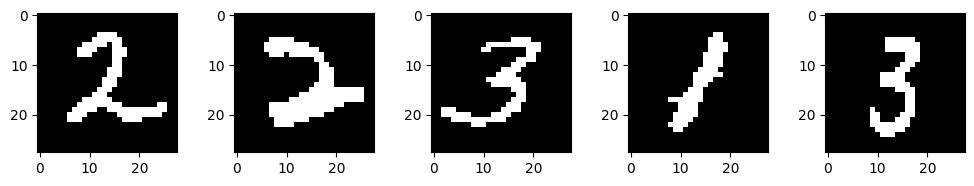

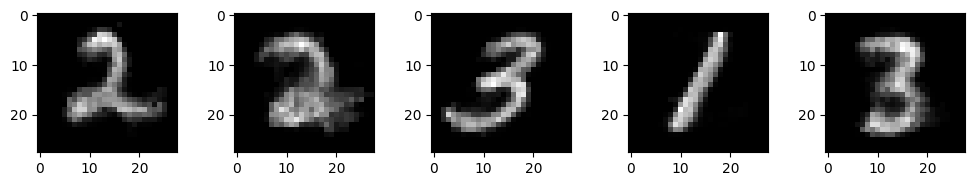

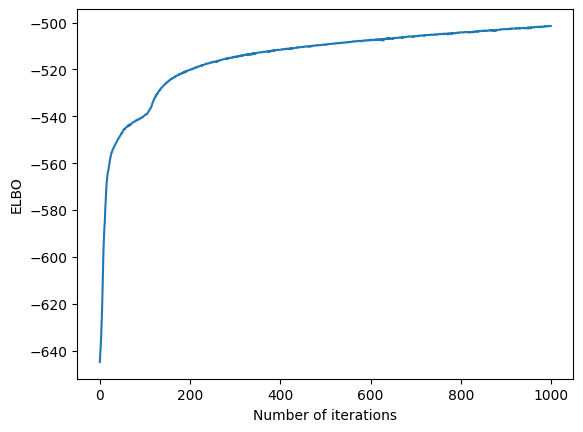

In [90]:
# Uncomment the following line if you want to play around with different data sets
#data, digits, number_of_images_from_each_class = get_data_sample(number_of_images_from_each_class = 1000)

z_dim=2

vae_non_linear = VAE(z_dim, encoder = FancyEncoder(z_dim, hidden_dim1 = 256, hidden_dim2 = 64), decoder = FancyDecoder(z_dim, hidden_dim1=64, hidden_dim2=256))

# Run options
LEARNING_RATE = 0.001

# Number of learning epochs
NUM_EPOCHS = 1000

# clear param store
pyro.clear_param_store()

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae_non_linear.model, vae_non_linear.guide, optimizer, loss=Trace_ELBO())
train_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, data.data)
    train_elbo.append(-total_epoch_loss_train)
    if (epoch % 100) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if (epoch % 500) == 0:
        vae_non_linear.reconstruct_image()
vae_non_linear.reconstruct_image()

plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()

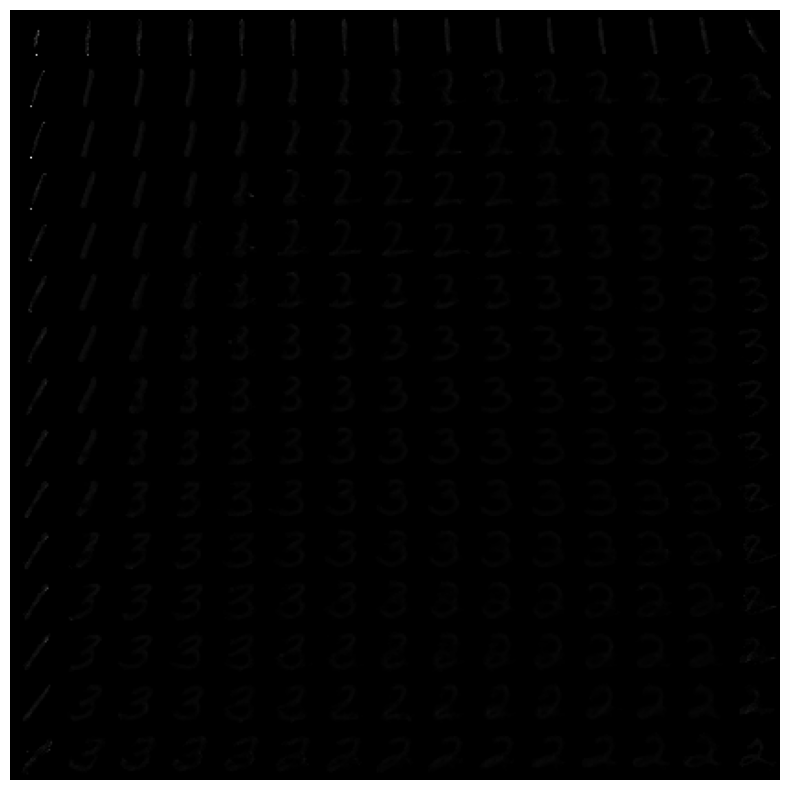

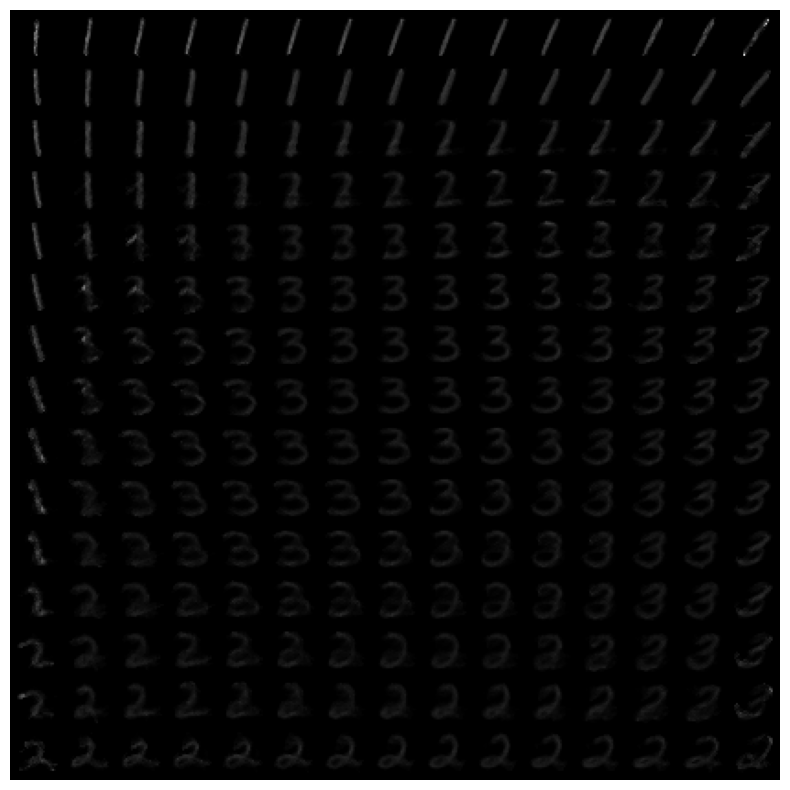

In [91]:
# Using the linear VAE
plot_latent_space(vae)
# Using the fancy VAE
plot_latent_space(vae_non_linear)

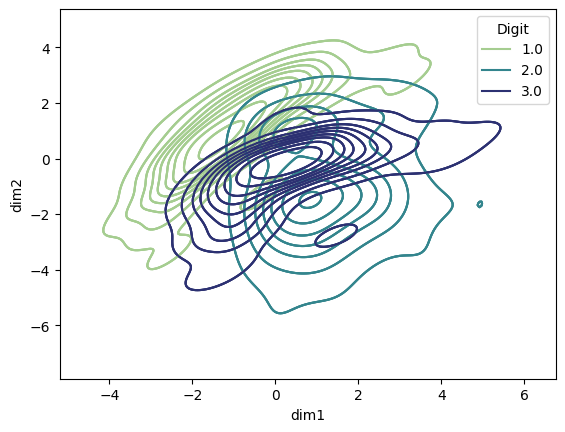

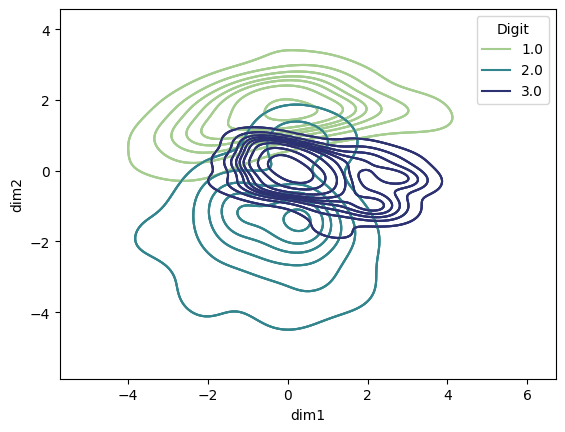

In [92]:
plot_posterior(vae)
plot_posterior(vae_non_linear)

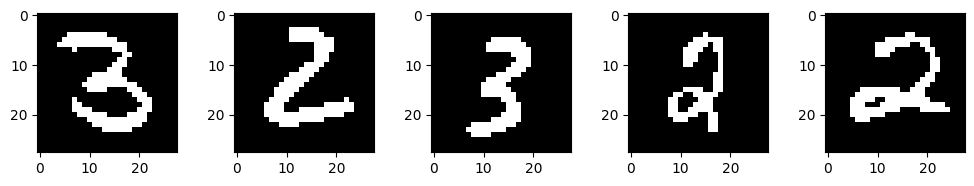

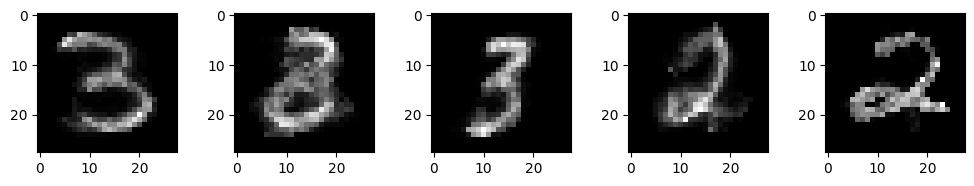

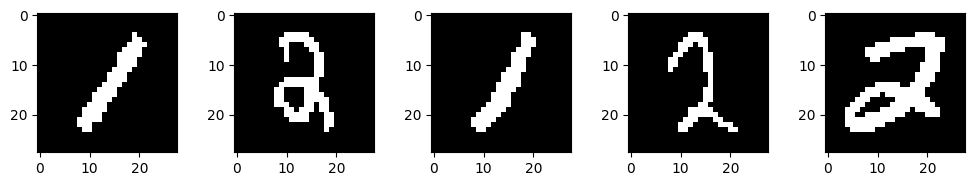

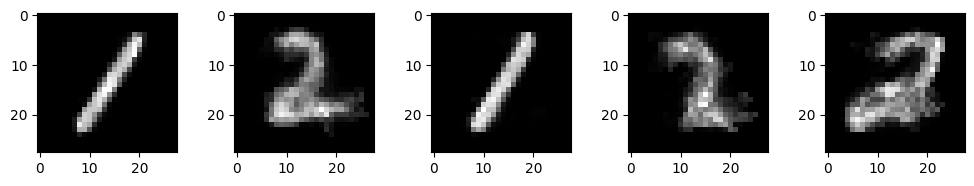

In [96]:
# Reconstruct images using the VAE
vae.reconstruct_image()
# Reconstruct images using the non-linear VAE
vae_non_linear.reconstruct_image()